# Checkpoint 2 Linear Model

In [5]:
from data_utils import *
from feature_utils import *


from pathlib import Path
from data_utils import get_images, get_labels
import re
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import warnings
from sklearn.ensemble import IsolationForest

from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split
# import cv2

In [6]:
# Getting local data path from config

with open('config.json') as config_file:
    config = json.load(config_file)
    data_dir = Path(config['data_dir'])

# Show all files in the data dir
list(data_dir.glob("*"))

[PosixPath('/home/jovyan/shared/sp24_grad_project_data/satellite-image-data/socal-fire'),
 PosixPath('/home/jovyan/shared/sp24_grad_project_data/satellite-image-data/midwest-flooding'),
 PosixPath('/home/jovyan/shared/sp24_grad_project_data/satellite-image-data/test_images_hurricane-matthew.npz'),
 PosixPath('/home/jovyan/shared/sp24_grad_project_data/satellite-image-data/test_images_flooding-fire.npz'),
 PosixPath('/home/jovyan/shared/sp24_grad_project_data/satellite-image-data/.ipynb_checkpoints'),
 PosixPath('/home/jovyan/shared/sp24_grad_project_data/satellite-image-data/hurricane-matthew')]

In [7]:
# Get Hurricane Matthew Images

disaster = "hurricane-matthew"
split = "train"

hurricane_train_images = get_images(data_dir, disaster, split=split)
hurricane_train_labels = get_labels(data_dir, disaster, split=split)
display(hurricane_train_labels)
# hurricane_train_images

array([3, 0, 1, ..., 2, 3, 0])

In [8]:
# Get Midwest Flooding

disaster = "midwest-flooding"
split = "train"

flood_train_images = get_images(data_dir, disaster, split=split)
flood_train_labels = get_labels(data_dir, disaster, split=split)
display(flood_train_labels)

array([0, 0, 0, ..., 0, 0, 0])

In [9]:
# Get Socal Fire

disaster = "socal-fire"
split = "train"

fire_train_images = get_images(data_dir, disaster, split=split)
fire_train_labels = get_labels(data_dir, disaster, split=split)
display(fire_train_labels)

array([0, 0, 0, ..., 0, 0, 0])

In [10]:
# Get the shape of the first image
display(hurricane_train_images[0].shape)

# Get the RGB values from the pixel at (0, 0)
hurricane_train_images[0][0][0]

(65, 54, 3)

array([58, 94, 83], dtype=uint8)

## Preprocessing and Feature Engineering

In [11]:
hurricane_image_shapes = np.array([i.shape for i in hurricane_train_images])
hurricane_heights = hurricane_image_shapes[:, 0]    # Heights are the number of rows
hurricane_widths = hurricane_image_shapes[:, 1]     # Widths are the number of columns

### 1. Create a Parent Dataframe

Create a parente dataframe for every disaster type

In [12]:
hurricane_df = pd.DataFrame(hurricane_train_labels.reshape(-1, 1), columns=['Disaster Level'])
hurricane_df['Fire'] = 0
hurricane_df

,Disaster Level,Fire
0,3,0
1,0,0
2,1,0
3,0,0
4,2,0
...,...,...
11146,3,0
11147,0,0
11148,2,0
11149,3,0


In [13]:
flood_df = pd.DataFrame(flood_train_labels.reshape(-1, 1), columns=['Disaster Level'])
flood_df['Fire'] = 0
flood_df

,Disaster Level,Fire
0,0,0
1,0,0
2,0,0
3,0,0
4,1,0
...,...,...
6999,0,0
7000,0,0
7001,0,0
7002,0,0


In [14]:
fire_df = pd.DataFrame(fire_train_labels.reshape(-1, 1), columns=['Disaster Level'])
fire_df['Fire'] = 1
fire_df

,Disaster Level,Fire
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
8375,0,1
8376,0,1
8377,0,1
8378,0,1


Perform feature engineering on each image.

In [15]:
def feature_engine(dataframe: pd.DataFrame,
                   image_list: List) -> pd.DataFrame:
    """
    Mutative function that takes in a dataframe and an list of NumPy arrays (images) to perform feature engineering on. 
    Appends the engineered features back to the dataframe.
    The DataFrame and the numpy array must be indexed the same for the features to be linked to the correct images

    Features:
        Average RGB - the average of the pixels in each of the RGB channels for each image
        Average Sobel - the average of the pixels of the image after Sobel filter is applied
        Average LBP - the average of the pixels of the Local Binary Pattern of the image
    
    Parameters:
        dataframe: pd.DataFrame
            The DataFrame holding the indexes of the images, to which we should append the features back into
        image_list: List
            The List of numpy array of images to perform feature engineering on. 
            Shape of NumPY array is (n, p, p, 3), where
                n = # of images,
                p = perfect_square size of the image,
                and 3 for the 3 RGB color channels of the image

    Returns:
        None - is a mutative function that mutates the passed in DataFrame            
    """
    avg_red = []
    avg_green = []
    avg_blue = []
    avg_sobel = []
    avg_lbp = []

    num_images = len(image_list)
    for image in tqdm(image_list):

        avg_red.append(np.mean(image[:, :, 0]))
        avg_green.append(np.mean(image[:, :, 1]))
        avg_blue.append(np.mean(image[:, :, 2]))
    
        avg_sobel.append(np.mean(get_sobel_features(image)))
        avg_lbp.append(np.mean(get_local_binary_pattern(image)))
        # dataframe['Average Sobel'] = np.mean(sobel_images.reshape(num_images, -1), axis=1)

    dataframe['Average Red'] = np.array(avg_red) / max(avg_red)
    dataframe['Average Green'] = np.array(avg_green) / max(avg_green)
    dataframe['Average Blue'] = np.array(avg_blue) / max(avg_blue)
    dataframe['Average Sobel'] = np.array(avg_sobel) / max(avg_sobel)
    dataframe['Average LBP'] = np.array(avg_lbp) / max(avg_lbp)

    return dataframe
    

In [16]:
hurricane_df = feature_engine(hurricane_df, hurricane_train_images)

100%|██████████| 11151/11151 [00:13<00:00, 813.50it/s]


In [17]:
hurricane_df

,Disaster Level,Fire,Average Red,Average Green,Average Blue,Average Sobel,Average LBP
0,3,0,0.315719,0.444336,0.445701,0.464934,0.684217
1,0,0,0.368891,0.504047,0.486109,0.305863,0.652446
2,1,0,0.466982,0.515602,0.524888,0.544758,0.687097
3,0,0,0.404457,0.542375,0.563169,0.210994,0.676822
4,2,0,0.363587,0.459122,0.424658,0.527758,0.610121
...,...,...,...,...,...,...,...
11146,3,0,0.343027,0.468564,0.490681,0.406126,0.623638
11147,0,0,0.305891,0.445628,0.406832,0.253186,0.649653
11148,2,0,0.363648,0.457029,0.397383,0.585320,0.678602
11149,3,0,0.224364,0.342550,0.309745,0.257962,0.687520


In [18]:
flood_df = feature_engine(flood_df, flood_train_images)
flood_df

100%|██████████| 7004/7004 [00:14<00:00, 488.38it/s]


,Disaster Level,Fire,Average Red,Average Green,Average Blue,Average Sobel,Average LBP
0,0,0,0.433470,0.504469,0.523070,0.157923,0.803000
1,0,0,0.402550,0.472104,0.455753,0.148558,0.817881
2,0,0,0.309034,0.403741,0.358727,0.172898,0.790341
3,0,0,0.535424,0.595264,0.555391,0.333437,0.773657
4,1,0,0.215312,0.347903,0.241495,0.181919,0.821750
...,...,...,...,...,...,...,...
6999,0,0,0.394024,0.495294,0.452934,0.162953,0.822714
7000,0,0,0.418615,0.530521,0.506274,0.220387,0.801013
7001,0,0,0.283374,0.381656,0.322845,0.162741,0.790759
7002,0,0,0.207397,0.322300,0.246146,0.143309,0.804953


In [19]:
fire_df = feature_engine(fire_df, fire_train_images)

100%|██████████| 8380/8380 [00:24<00:00, 345.95it/s]


In [20]:
fire_df

,Disaster Level,Fire,Average Red,Average Green,Average Blue,Average Sobel,Average LBP
0,0,1,0.579382,0.659187,0.628787,0.299332,0.731645
1,0,1,0.369430,0.450330,0.435473,0.283644,0.713115
2,0,1,0.510691,0.614722,0.556578,0.264404,0.734214
3,0,1,0.506770,0.568372,0.538609,0.272281,0.725026
4,0,1,0.401874,0.519145,0.493923,0.229995,0.743659
...,...,...,...,...,...,...,...
8375,0,1,0.516755,0.609571,0.596710,0.276592,0.738321
8376,0,1,0.486930,0.568288,0.522717,0.206097,0.753503
8377,0,1,0.415937,0.497151,0.513454,0.254863,0.718321
8378,0,1,0.455177,0.554696,0.512527,0.285864,0.735451


In [21]:
flood_fire_df = pd.concat([flood_df, fire_df], ignore_index=True)
flood_fire_df

,Disaster Level,Fire,Average Red,Average Green,Average Blue,Average Sobel,Average LBP
0,0,0,0.433470,0.504469,0.523070,0.157923,0.803000
1,0,0,0.402550,0.472104,0.455753,0.148558,0.817881
2,0,0,0.309034,0.403741,0.358727,0.172898,0.790341
3,0,0,0.535424,0.595264,0.555391,0.333437,0.773657
4,1,0,0.215312,0.347903,0.241495,0.181919,0.821750
...,...,...,...,...,...,...,...
15379,0,1,0.516755,0.609571,0.596710,0.276592,0.738321
15380,0,1,0.486930,0.568288,0.522717,0.206097,0.753503
15381,0,1,0.415937,0.497151,0.513454,0.254863,0.718321
15382,0,1,0.455177,0.554696,0.512527,0.285864,0.735451


### Task A: Disaster Type Classification

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [23]:
type_design_matrix = flood_fire_df.drop(columns=['Fire', 'Disaster Level'])
X_train, X_test, y_train, y_test = train_test_split(type_design_matrix.to_numpy(), 
                                                    flood_fire_df['Fire'].to_numpy(), 
                                                    test_size=0.2, 
                                                    random_state=42)

In [24]:
type_classifier_log = LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear').fit(X_train, y_train)

In [25]:
isfire_train_pred = type_classifier_log.predict(X_train)
assert(len(isfire_train_pred) == len(y_train))

In [26]:
np.sum(isfire_train_pred == y_train) / len(y_train)

0.9696107906069716

In [27]:
isfire_test_pred = type_classifier_log.predict(X_test)
assert(len(isfire_test_pred) == len(y_test))

In [28]:
print(f'Accuracy of Logistic Regression Model for Task A is {np.sum(isfire_test_pred == y_test) / len(y_test)}')

Accuracy of Logistic Regression Model for Task A is 0.9652258693532662


In [29]:
cnf_matrix = confusion_matrix(y_test, isfire_test_pred)
cnf_matrix

array([[1336,   64],
       [  43, 1634]])

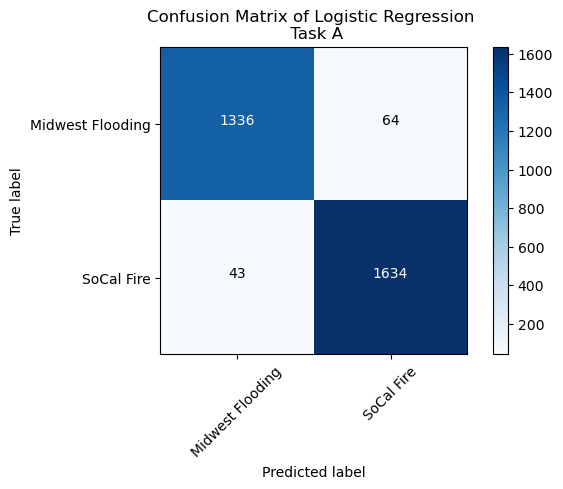

In [30]:
# Run this cell to plot the confusion matrix; no further action is needed.

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    import itertools

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.grid(False)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, np.round(cm[i, j], 2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
class_names = ['Midwest Flooding', 'SoCal Fire']

plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion Matrix of Logistic Regression \n Task A')

In [31]:
f1 = f1_score(y_test, isfire_test_pred)

print("F1 Score for Task A:", f1)

F1 Score for Task A: 0.9682962962962963


### Task B: Disaster Severity Classification

In [32]:
hurricane_fire_flood_df = pd.concat([hurricane_df, flood_df, fire_df], ignore_index=True)
hurricane_fire_flood_df

,Disaster Level,Fire,Average Red,Average Green,Average Blue,Average Sobel,Average LBP
0,3,0,0.315719,0.444336,0.445701,0.464934,0.684217
1,0,0,0.368891,0.504047,0.486109,0.305863,0.652446
2,1,0,0.466982,0.515602,0.524888,0.544758,0.687097
3,0,0,0.404457,0.542375,0.563169,0.210994,0.676822
4,2,0,0.363587,0.459122,0.424658,0.527758,0.610121
...,...,...,...,...,...,...,...
26530,0,1,0.516755,0.609571,0.596710,0.276592,0.738321
26531,0,1,0.486930,0.568288,0.522717,0.206097,0.753503
26532,0,1,0.415937,0.497151,0.513454,0.254863,0.718321
26533,0,1,0.455177,0.554696,0.512527,0.285864,0.735451


In [33]:
design_matrix = hurricane_fire_flood_df[['Average Red', 'Average Green', 'Average Blue', 'Average Sobel', 'Average LBP']]
X_train, X_test, y_train, y_test = train_test_split(design_matrix.to_numpy(), hurricane_fire_flood_df['Disaster Level'].to_numpy(), test_size=0.2, random_state=42)

In [34]:
image_classifier_lm = lm.LinearRegression().fit(X_train, y_train)

In [35]:
results = image_classifier_lm.predict(X_train)
results = np.round(results)
results

array([1., 0., 0., ..., 1., 0., 0.])

In [36]:
assert(results.shape == y_train.shape)

In [37]:
np.sum(results == y_train) / len(y_train)

0.6402393065762201

In [38]:
test_results = image_classifier_lm.predict(X_test)

In [39]:
test_results = np.round(test_results)

In [40]:
np.sum(test_results == y_test) / len(y_test)

0.625023553796872

In [41]:
from sklearn.linear_model import Ridge
ridge = Ridge().fit(X_train, y_train)
print(f"Ridge Regression-Training set score: {ridge.score(X_train, y_train):.2f}")
print(f"Ridge Regression-Test set score: {ridge.score(X_test, y_test):.2f}")

Ridge Regression-Training set score: 0.26
Ridge Regression-Test set score: 0.23


In [42]:
ridge_results = ridge.predict(X_train)

In [43]:
np.sum(np.round(ridge_results) == y_train) / len(y_train)

0.6443847748257019

In [44]:
ridge_results_test = ridge.predict(X_test)

In [45]:
np.sum(np.round(ridge_results_test) == y_test) / len(y_test)

0.6267194271716601

#### Utilize Logistic Regression

In [46]:
image_classifier_logistic = LogisticRegression(multi_class='multinomial', max_iter = 1000).fit(X_train, y_train)
image_classifier_logistic

LogisticRegression(max_iter=1000, multi_class='multinomial')

In [47]:
train_predictions = image_classifier_logistic.predict(X_train)
assert(train_predictions.shape == y_train.shape)

In [48]:
np.sum(train_predictions == y_train) / len(y_train)

0.738599962313925

In [49]:
test_predictions = image_classifier_logistic.predict(X_test)
assert(test_predictions.shape == y_test.shape)

In [50]:
print(f'Accuracy of Logistic Regression Model for Task B is {np.sum(test_predictions == y_test) / len(y_test)}')

Accuracy of Logistic Regression Model for Task B is 0.7339363105332579


In [51]:
cnf_matrix = confusion_matrix(y_test, test_predictions)
cnf_matrix

array([[2991,  289,    3,   25],
       [ 214,  860,    1,   14],
       [  96,  209,    0,   29],
       [ 398,  130,    4,   44]])

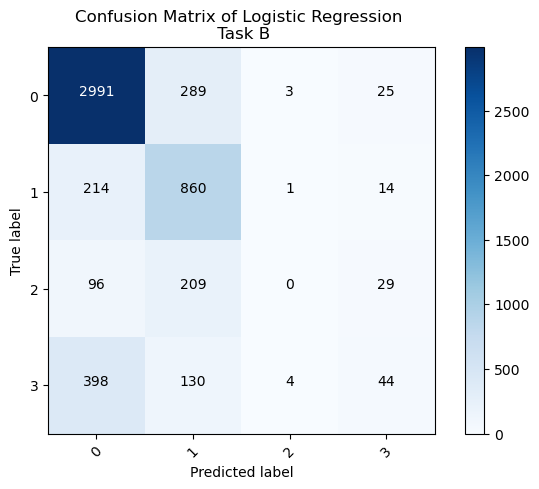

In [52]:
class_names = ['0', '1', '2', '3']

plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion Matrix of Logistic Regression \n Task B')

In [53]:
f1 = f1_score(y_test, test_predictions, average='weighted')

print("F1 Score for Task B:", f1)

F1 Score for Task B: 0.6829880864767933


## Test Set

In [59]:
data = np.load('/home/jovyan/shared/sp24_grad_project_data/satellite-image-data/test_images_flooding-fire.npz')
task_a_images = [data[f"image_{i}"] for i in range(len(data.files))]

In [61]:
data = np.load('/home/jovyan/shared/sp24_grad_project_data/satellite-image-data/test_images_hurricane-matthew.npz')
task_b_images = [data[f"image_{i}"] for i in range(len(data.files))]

In [69]:
task_a_features = feature_engine(pd.DataFrame(), task_a_images)
task_a = type_classifier_log.predict(task_a_features)

100%|██████████| 3847/3847 [00:09<00:00, 389.71it/s]
/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [74]:
task_a_df = pd.Series(task_a, name='pred')
task_a_df

0       1
1       0
2       0
3       1
4       1
       ..
3842    0
3843    0
3844    0
3845    1
3846    1
Name: pred, Length: 3847, dtype: int64

In [77]:
task_a_df.to_csv("test_images_flooding-fire_predictions.csv", index=False)

In [76]:
task_b_features = feature_engine(pd.DataFrame(), task_b_images)
task_b = image_classifier_logistic.predict(task_b_features)
task_b_df = pd.Series(task_b, name='pred')


100%|██████████| 2788/2788 [00:03<00:00, 793.12it/s]
/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [78]:
task_b_df.to_csv("test_images_hurricane-matthew_predictions.csv", index=False)

----------------------------------------

Tests for scaling, not actually required

### Scaling Image to Nearest Perfect Square

I want to perform a more advanced scaling operation. The end result is that all images should be square, but what size should the output image be? Determine bins for scaling based off image original area. If an image's original area falls within the bin range, then we shall scale the image to fit the dimensions that are the middle of that bin. eg. an image's area is ~400 pixels^2, and our bin is from 350-450 so we will scale it to a 20x20 image. The middle of the bins must thus all be perfect squares.

#### Potential Ideas
- Can make 5-10 bins based off the maximum area found in the whole dataset.
  - However, a majority of images fall within a certain area. This could create more bins for the outliers and not enough bins for the majority of the dataset
- Make more bins for the highest density area values, and less bins for the outliers (really large/small images)

Based off the logic above, make a bin for every perfect square up to the perfect square that is >= the largest area in the dataset. Each image will be scaled to its closest perfect square!

#### Potential Steps for Scaling:

Create a dictionary where keys are perfect squares, and the values are lists containing all the images that should be scaled to a square image
with dimensions of that perfect square. To calculate the nearest perfect square, calculate the area of the original image, then round the square
root of the area to the nearest integer = the nearest perfect square of the image.

Can then perform scaling for every perfect square in the dictionary, and then perform feature engineering on square images of different dimensions
Since the goal is to create simpler features for the model, such as average value for each R/G/B channel or average of the Sobel edge detection filter,
the different square pictures will not matter at the end.

Must figure out how to link features back to the original images, since they will no longer be in order after sorting images by closest perfect square

#### Scaling Pipeline

Design a feature engineering pipeline

1. Create a parent dataframe with the Y_value (severity level) for each image
2. For each image, determine its nearest perfect square. Append that to the parent dataframe
3. Create a dictionary with each unique perfect square as a key, and each subset of the parent dataframe with only images of that perfect square as values: perfect_square_df
4. For each key:dataframe pair in the dictionary, use the indices to index into the original list of all images to select the corresponding images to be scaled to the key's square size. The scaled images will all be of the same size and can be placed into a numpy array.
5. Generate features from those square images. Example features could be:
   - The average value of each of the R/G/B color channels.
   - The average value of the pixels in the image after Sobel edge filtering
6. Append the features back into perfect_square_dataframe. 
7. Merge back into the parent_df on indices (they should still be the same). Final parent_df will only have features and severity label, not any individual pixel information



### Feature Functions

def closest_perfect_square(image_shapes: np.ndarray) -> np.array(int):
    """
    Find the nearest perfect square P of the image area, such that we can rescale the image to a new square PxP image.
    If an image has an area of 425, we would want to rescale the image to a 20x20 square image, so the nearest perfect square would be 20.

    Parameters:
        image_shapes (numpy.ndarray): 
            array of shape (n, 3) for n images. Each image should have 3 (rows, columns, RGB), where the last dimension RGB is an additional
            array of shape (3,) for each color channel. Conceptually, an image is a matrix where each entry is an array of (3, )

    Returns:
        nearest_ps (np.ndarray of ints): the array of integers of the nearest perfect square for each image
    """
    area = image_shapes[:, 0] * image_shapes[:, 1]
    nearest_ps = np.round(np.sqrt(area))
    return nearest_ps.astype(int)

def scale_image(images: List[np.ndarray], 
                square_size: int
                ) -> np.ndarray:
    """
    Using the OpenCV library, perform scaling of each image to a square image that it is closest in area to.
    Also returns the pixel values normalized (divided by 255)

    Parameters:
        images (List[np.ndarray(int)]): List of numpy arrays, each numpy array is an image to be scaled
        square_size (int): the new square_size x square_size square image to scale the image to

    Returns:
        squared_images (np.ndarray(int)): Numpy array of shape (n, square_size, square_size, 3) for n images in images list.
            Each entry into the array is now a scaled image
    """

    return np.array([cv2.resize(image, (square_size, square_size)).astype(np.float32) / 255.0 for image in images])



# Testing of Feature Functions

# Closest_Perfect_Square
display(closest_perfect_square(hurricane_image_shapes))
assert(closest_perfect_square(np.array([[10, 11, 1]]))[0] == 10)

# Scale_Image
assert(scale_image(hurricane_train_images, 50).shape[1] == 50)
assert(scale_image(hurricane_train_images, 80).shape[1] == 80)
scale_image(hurricane_train_images, 10).shape


### 2. Find the nearest perfect square for each image

hurricane_df['Closest_PS'] = closest_perfect_square(hurricane_image_shapes)
hurricane_df.head()

### 3. Create perfect square specific dataframes in a dictionary

ps_dataframes = {}
for perfect_square in hurricane_df['Closest_PS'].unique():
    ps_dataframes[perfect_square] = hurricane_df[hurricane_df['Closest_PS'] == perfect_square]
ps_dataframes[59]

### 4/5/6

Perform scaling for each perfect_square dataframe

Use the indices from each ps_dataframe to index into the original dataset list, `hurricane_train_images`. Then use that list subset to scale the image to its closest perfect square (as denoted by its key).

Append the features back into the perfect_square dataframe

In [209]:
final_df = pd.DataFrame()

for dataframe in ps_dataframes.values():
    final_df = pd.concat([dataframe, final_df])
# final_df = pd.concat([ps_dataframes[59], final_df])
final_df = final_df.sort_index()
final_df

,Disaster Level,Closest_PS,Average Red,Average Green,Average Blue,Average Sobel
0,3,59,0.296417,0.412363,0.395898,0.049479
1,0,84,0.346463,0.467902,0.431940,0.036116
2,1,55,0.438617,0.478575,0.466326,0.058030
3,0,119,0.379843,0.503448,0.500393,0.023963
4,2,54,0.341406,0.426117,0.377319,0.061631
...,...,...,...,...,...,...
11146,3,52,0.322053,0.434843,0.435957,0.047434
11147,0,53,0.287214,0.413574,0.361365,0.029131
11148,2,47,0.341460,0.424133,0.353014,0.061884
11149,3,43,0.210556,0.317821,0.275061,0.027422


In [161]:
scaled_images[:, :, :, 0].reshape(scaled_images.shape[0], -1).shape

(184, 3481)

In [167]:
np.mean(scaled_images[:, :, :, 0].reshape(scaled_images.shape[0], -1), axis=1).shape

(184,)

#### Feature engineering for every perfect square dataframe

for ps, dataframe in ps_dataframes.items():
    indices = list(ps_dataframes[ps].index)
    img_list = [hurricane_train_images[i] for i in indices]
    scaled_images = scale_image(img_list, ps)
    feature_engine(dataframe, scaled_images)


### 7. Merge each subdf back into main df